# Notebook pour l'entrainement et l'exécution d'un réseau faster-RCNN pour la détection de la tête des nageurs


### Connexion à Google Drive où sont stockées les données annotées et le modèle déjà entrainé à ce jour

Le chemin en argument de os.chdir doit être de la forme 'gdrive/My Drive/votre_dossier' . Le notebook doit être placé à l'intérieur de 'votre_dossier' (à renommer).

Pour l'entrainement :

A l'intérieur de 'votre_dossier' doit se trouver un dossier 'swimmer' . Ce dossier 'swimmer' doit contenir d'une part un csv contenant les annotations et un dossier 'images' contenant toutes les images nécessaires à l'entrainement. Décompressez 'images.rar' si ce n'est pas déjà fait.

Lien github contenant les fichiers et les data : https://github.com/tcourat/RCNN

En particulier le fichier *modelfin_swimmer* contenant les poids du réseau déjà entrainé sur 25 epochs est disponible dans les releases : https://github.com/tcourat/RCNN/releases/tag/1.0  . Il faut le placer dans le dossier 'swimmer'.

In [1]:
#import pycotools
import os

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/Stage_LIRIS/pytorch_object_detection') 

Mounted at /content/gdrive


### Import des différents modules nécessaires

Pour les modules engine, transforms et utils il faut télécharger tous les fichiers .py depuis le github suivant : https://github.com/pytorch/vision/tree/master/references/detection et les déposer dans 'votre_dossier' .


In [2]:
import numpy as np
import torch
import torch.utils.data
import torchvision
from PIL import Image, ImageDraw
import pandas as pd

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from engine import train_one_epoch, evaluate
import utils
import transforms as T  
import matplotlib.pyplot as plt
import cv2

# Création des chemins

In [52]:
nom_csv = 'labels_nageur.csv' #nom du csv contenant les annotations
nom_image = 'images' #nom du dossier contenant les images
nom_save_model ='model_light_anchor_test3' #nom du modele sauvegarde apres training
nom_load_model ='modelfin_swimmer' #nom du modele a charger pour les inferences

### Création de la classe « SwimmerDataset »


In [4]:
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["xmin", "ymin","xmax", "ymax"]].values 
   
    return boxes_array

class SwimmerDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, nom_image)))
        self.path_to_data_file = data_file
    
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root,nom_image, self.imgs[idx]) 
        img = Image.open(img_path).convert("RGB") 
        box_list = parse_one_annot(self.path_to_data_file, 
        self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        
        # only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,
        0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            return img, target
        
    def __len__(self):
        return len(self.imgs)


### Définition de *get_model* et *get_transform*

On commence par créer une fonction *get_model* qui va instancier un modèle fasterrcnn_resnet50_fpn préentrainé duquel on réinitialise la dernière couche chargée de la prédiction des bounding box. On définit ensuite une seconde fonction *get_transform* qui va concaténer toutes les transformations appliquées aux data avant d'être entrainées ( transformation en tensor puis data augmentation ).

In [5]:
def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

   #create an anchor_generator for the FPN which by default has 5 outputs
   anchor_generator = AnchorGenerator(sizes=((4,), (8,), (16,), (32,), (64,)), aspect_ratios=tuple([(0.5, 1.0, 2.0) for _ in range(5)]))
        
   # get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features
    
   # replace the pre-trained head with a new on
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
   return model

def get_transform(train):
    transformslist = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transformslist.append(T.ToTensor())

    if train:
        # data augmentation
        transformslist.append(T.RandomHorizontalFlip(0.5))
        transformslist.append(T.RandomPhotometricDistort())

    return T.Compose(transformslist)

### Création du dataset d'entrainement et de validation

Ici on instancie notre dataset d'entrainement (80%) et de validation (20%) en faisant un shuffle au préalable. 

C'est dans *data_loader_train* que l'on peut changer le batch_size pour l'entrainement.

C'est aussi ici que l'on renseigne le chemin vers le csv contenant les annotations.

In [48]:
# use our dataset and defined transformations
dataset = SwimmerDataset(root= "swimmer",
          data_file= "swimmer/"+nom_csv ,
          transforms = get_transform(train=True))

dataset_test = SwimmerDataset(root= "swimmer",
               data_file= "swimmer/"+nom_csv ,
               transforms = get_transform(train=False))

# split the dataset between train and test set

#torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

nb_test = int(0.2*len(dataset))
dataset = torch.utils.data.Subset(dataset, indices[:-nb_test])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-(nb_test):])

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
              dataset, batch_size=4, shuffle=True, num_workers=0,
              collate_fn=utils.collate_fn) #batch_size here
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=0,
         collate_fn=utils.collate_fn)
print("Le dataset contient {} images, {} pour l'entrainement et {} pour la validation".format(len(indices), len(dataset), len(dataset_test)))



Le dataset contient 205 images, 164 pour l'entrainement et 41 pour la validation


### Instanciation du modèle RCNN

On commence par choisir comme device le GPU si la technologie CUDA est disponible, ce qui accélère grandement les calculs sinon on se place sur le CPU.

Puis on instancie notre modèle RCNN ainsi que l'optimiseur associé (ici SGD). On peut changer lr (learning_rate), momentum et weight_decay .

On peut choisir de faire décroitre le learning rate d'un facteur *gamma* tous les *step_size* epoch via *lr_scheduler*. 

In [49]:
# use GPU if CUDA is available otherwise use CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

# get the model 
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate over epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### Entrainement du réseau

Dans la cellule suivante on procède à l'entrainement du réseau. On peut choisir le nombre d'epoch et également la fréquence à laquelle la loss est affiché pendant l'entrainement.

Au fur et à mesure de l'entrainement l'évaluateur affiche les différentes métriques de performances en précision et en recall pour plusieurs échelles différentes et plusieurs IoU ( intersection over union entre la box annotée et la box prédite ) sur le dataset de validation.


In [50]:
num_epochs = 10
liste_training_loss = []
liste_training_loss_classifier = []
liste_training_loss_box_reg = []
liste_training_loss_objectness = []
liste_training_loss_rpn_box_reg = []
liste_validation_precision_50 = []
liste_validation_precision_75 = []
liste_validation_precision_avg_50_95 = []
liste_validation_rappel_maxDets100 = []


for epoch in range(num_epochs):
  # train for one epoch
  training = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=40) #print every print_freq batches
    
  # update the learning rate
  lr_scheduler.step()

  # evaluate on the test dataset
  validation = evaluate(model, data_loader_test, device=device)

  for iou_type, coco_eval in validation.coco_eval.items() :
    avg_precision_avg_50_95 =  coco_eval.stats[0] # Average Precision  (AP) @[ IoU=0.50:0.95 | area=  all | maxDets=100 ]
    avg_precision_50 = coco_eval.stats[1] # Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] 
    avg_precision_75 = coco_eval.stats[2] # Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] 
    avg_rappel_maxDets100 = coco_eval.stats[8] # Average Recall  (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  100 ] 
    

  liste_training_loss.append(training.meters['loss'].global_avg) 
  liste_training_loss_classifier.append(training.meters['loss_classifier'].global_avg) 
  liste_training_loss_box_reg.append(training.meters['loss_box_reg'].global_avg) 
  liste_training_loss_objectness.append(training.meters['loss_objectness'].global_avg)
  liste_training_loss_rpn_box_reg.append(training.meters['loss_rpn_box_reg'].global_avg)
  liste_validation_precision_50.append(avg_precision_50)
  liste_validation_precision_75.append(avg_precision_75)
  liste_validation_precision_avg_50_95.append(avg_precision_avg_50_95)
  liste_validation_rappel_maxDets100.append(avg_rappel_maxDets100)
  

Epoch: [0]  [ 0/41]  eta: 0:02:13  lr: 0.000260  loss: 0.6951 (0.6951)  loss_classifier: 0.5832 (0.5832)  loss_box_reg: 0.0831 (0.0831)  loss_objectness: 0.0224 (0.0224)  loss_rpn_box_reg: 0.0063 (0.0063)  time: 3.2560  data: 0.0382  max mem: 9009
Epoch: [0]  [40/41]  eta: 0:00:02  lr: 0.010000  loss: 0.2042 (0.2804)  loss_classifier: 0.0688 (0.1401)  loss_box_reg: 0.1159 (0.1174)  loss_objectness: 0.0038 (0.0184)  loss_rpn_box_reg: 0.0030 (0.0045)  time: 2.9051  data: 0.0458  max mem: 9274
Epoch: [0] Total time: 0:02:00 (2.9304 s / it)
creating index...
index created!
Test:  [ 0/41]  eta: 0:00:12  model_time: 0.2888 (0.2888)  evaluator_time: 0.0021 (0.0021)  time: 0.2992  data: 0.0081  max mem: 9274
Test:  [40/41]  eta: 0:00:00  model_time: 0.2884 (0.2927)  evaluator_time: 0.0018 (0.0021)  time: 0.3043  data: 0.0085  max mem: 9274
Test: Total time: 0:00:12 (0.3035 s / it)
Averaged stats: model_time: 0.2884 (0.2927)  evaluator_time: 0.0018 (0.0021)
Accumulating evaluation results...
DO

###  Graphiques de l'évolution de la loss, de la précision et du rappel au cours de l'entrainement

No handles with labels found to put in legend.


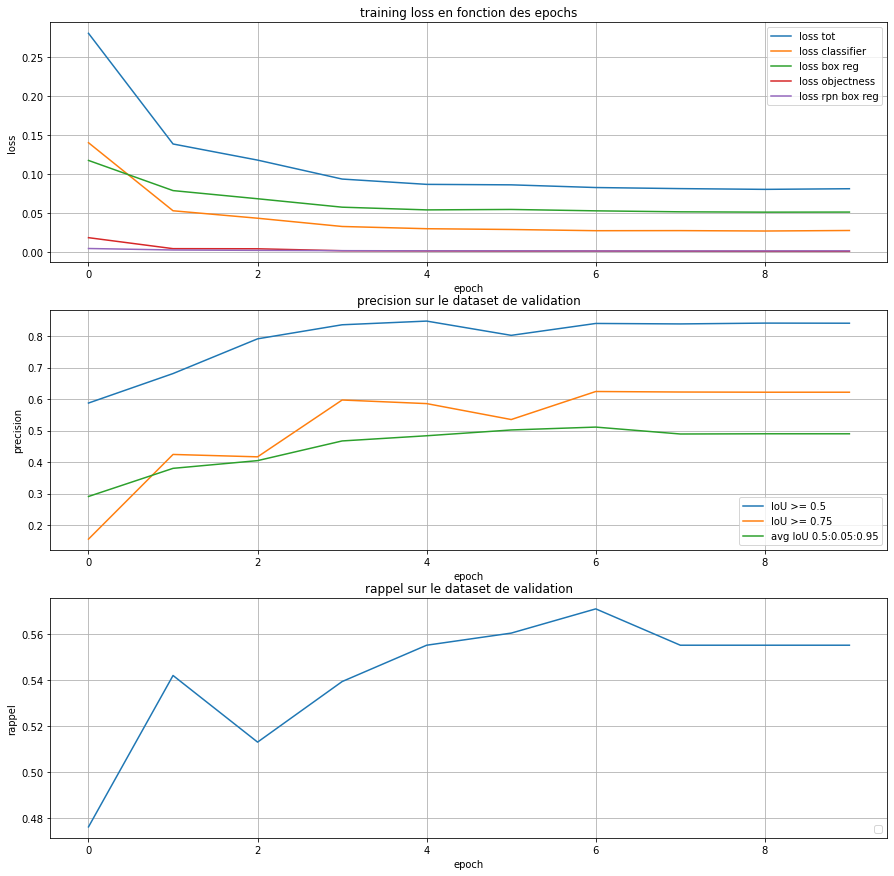

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,15))
n = len(liste_training_loss)

ax1.plot(range(n), liste_training_loss, label='loss tot')
ax1.plot(range(n), liste_training_loss_classifier,label='loss classifier')
ax1.plot(range(n), liste_training_loss_box_reg,label='loss box reg')
ax1.plot(range(n), liste_training_loss_objectness ,label='loss objectness')
ax1.plot(range(n), liste_training_loss_rpn_box_reg,label='loss rpn box reg')
ax1.set_title('training loss en fonction des epochs')
ax1.set(xlabel='epoch', ylabel='loss')

ax2.plot(range(n), liste_validation_precision_50, label='IoU >= 0.5'  )
ax2.plot(range(n), liste_validation_precision_75, label='IoU >= 0.75'  )
ax2.plot(range(n), liste_validation_precision_avg_50_95, label='avg IoU 0.5:0.05:0.95')
ax2.set_title('precision sur le dataset de validation')
ax2.set(xlabel='epoch', ylabel='precision')

ax3.plot(range(n), liste_validation_rappel_maxDets100)
ax3.set(xlabel='epoch', ylabel='rappel')
ax3.set_title('rappel sur le dataset de validation')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

ax1.grid()
ax2.grid()
ax3.grid()

plt.savefig('swimmer/models/'+nom_save_model+'.png')

plt.show()

### Sauvegarde du modèle entrainé 

On peut ensuite sauvegarder les poids du modèle entrainé sur le drive.

In [9]:
#Save the model
torch.save(model.state_dict(), "swimmer/models/"+nom_save_model)

### Charger un modèle déjà existant et le tester sur une image ou une vidéo

On définit le chemin vers le fichier contenant les poids du RCNN obtenus à la suite de l'entrainement.

La première cellule permet de tester directement le modèle sur les images du dataset de validation s'il a été chargé. Pour cela il suffit de choisir l'indice de l'image à tester (idx)  

La deuxième cellule permet de tester le modèle sur une image quelconque.

La troisième cellule permet de tester le modèle sur une vidéo zoomée. Il faut préciser le chemin vers la vidéo. Sans accélération par un GPU, les calculs sont longs (environ 4 secondes par frame de vidéo de taille 256x256) . Il faut préciser le chemin vers la vidéo.

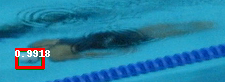

In [41]:
# test sur une image du dataset de validation

def analyser_image_data(idx, seuil, model_path) :
  """
  Parametres :
  idx : indice de l image dans le dataset de validation
  seuil : score minimal des detections a considerer
  model_path : chemin vers le modele a utiliser

  Resultat :
  print l image d indice idx du dataset de validation avec des bounding box
  correspondant aux detections realisees par le Faster-RCNN 
  """
  # use GPU if CUDA is available otherwise use CPU
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

  loaded_model = get_model(num_classes = 2)
  loaded_model.load_state_dict(torch.load(model_path+"/"+nom_load_model, map_location=device))
  loaded_model.to(device)


  img, _ = dataset_test[idx]
  img = img.to(device)
  
  label_boxes = np.array(dataset_test[idx][1]["boxes"])

  #put the model in evaluation mode
  loaded_model.eval()
  with torch.no_grad():
      prediction = loaded_model([img])
  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().cpu().numpy())
  draw = ImageDraw.Draw(image)

  # rouge = prediction, vert = box annotee
  for elem in range(len(label_boxes)):
      draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
      (label_boxes[elem][2], label_boxes[elem][3])], 
      outline ="green", width =3)

  for element in range(len(prediction[0]["boxes"])):
      boxes = prediction[0]["boxes"][element].cpu().numpy()
      score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                      decimals= 4)
      
      if score >= seuil :
          draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
          outline ="red", width =3)
          draw.text((boxes[0], boxes[1]), text = str(score))

  return image

analyser_image_data(12,0.8,'swimmer/models')

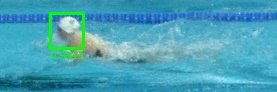

In [42]:
# test sur une image quelconque

from google.colab.patches import cv2_imshow #cv2.imshow ne fonctionne pas avec Colab

def analyser_image(image_path, seuil, model_path) :
  """
  Parametres :
  image_path : chemin vers l image
  seuil : score minimal des detections a considerer
  model_path : chemin vers le modele a utiliser

  Resultat :
  print l'image d'indice  avec des bounding box
  correspondant aux detections realisees par le Faster-RCNN 
  """
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

  loaded_model = get_model(num_classes = 2)
  loaded_model.load_state_dict(torch.load(model_path+'/'+nom_load_model, map_location=device))
  loaded_model.to(device)

  img_cv = cv2.imread(image_path)
  img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
  img= T.ToTensor()(img)[0].to(device)
 
  #put the model in evaluation mode
  loaded_model.eval()
  with torch.no_grad():
      prediction = loaded_model([img])
  
  for element in range(len(prediction[0]["boxes"])):
      boxes = prediction[0]["boxes"][element].cpu().numpy()
      score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                      decimals= 4)
      
      
      if score >= seuil:
        top_left = (int(boxes[0]), int(boxes[1]))
        bottom_right = (int(boxes[2]), int(boxes[3]))
        img_cv = cv2.rectangle(img_cv, top_left, bottom_right, (0,255,0),2)
        img_cv = cv2.putText(img_cv, str(score), (top_left[0], bottom_right[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255,0), 1)

  cv2_imshow(img_cv)
  

analyser_image('swimmer/images/above140.png',0.8, "swimmer/models")

In [40]:
# test sur une video

def analyser_video(video_path, out_path, seuil, model_path) :
  """
  Parametres :
  video_path : chemin vers la video
  out_path : endroit ou ecrire la video resultat
  seuil : score minimal des detections a considerer
  model_path : chemin vers le modele a utiliser

  Resultat :
  ecrit une video a l emplacement demande dont chaque frame fait apparaître les
  bounding box detectees par le Faster-RCNN avec le seuil demande
  
  renvoie une liste box_head tel que pour chaque frame i, box_head[i] est une 
  liste de listes de la forme [num_frame, top_left, bottom_right] pour chaque 
  bounding box sur la frame i
  """

  # use GPU if CUDA is available otherwise use CPU
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

  loaded_model = get_model(num_classes = 2)
  loaded_model.load_state_dict(torch.load(model_path+"/"+nom_load_model, map_location=device))
  loaded_model.to(device)

  box_head = []

  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)  # float 
  height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # float
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(out_path, fourcc, fps, (int(width),  int(height)))
  length = cap.get(cv2.CAP_PROP_FRAME_COUNT)

  #put the model in evaluation mode
  loaded_model.eval()
  with torch.no_grad():

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()
        num_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        print(str(num_frame)+' sur '+str(length))

        if ret :
          img = frame
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #passage en RGB 
          im_tensor = T.ToTensor()(img)[0].to(device) #conversion en tensor 

        
          detection = loaded_model([im_tensor])

          
          N = len(detection[0]['boxes']) #nombre de detection 
          boxes = []
          for n in range(N) : 
            xmin, ymin,xmax, ymax = detection[0]['boxes'][n]
            score = detection[0]['scores'][n].item()

            if score>= seuil : 
              top_left = (int(xmin.item()), int(ymin.item()))
              bottom_right = (int(xmax.item()), int(ymax.item()))
              frame = cv2.rectangle(frame, top_left,bottom_right , (0,255,0), 2)
              boxes.append([num_frame, top_left, bottom_right])
              

          box_head.append(boxes)

              
          out.write(frame)

        else :
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    return box_head

box_head = analyser_video('swimmer/zoom_good_brasse_4K_1.mp4', 'swimmer/resultats/zoom_good_brasse_4K_out2.avi', 0.8, "swimmer/models")
print(box_head) #pour chaque frame i, box_head[i] est une liste contenant de listes de la forme [num_frame, top_left, bottom_right] pour chaque bounding box

1.0 sur 963.0
2.0 sur 963.0
3.0 sur 963.0
4.0 sur 963.0
5.0 sur 963.0
6.0 sur 963.0
7.0 sur 963.0
8.0 sur 963.0
9.0 sur 963.0
10.0 sur 963.0
11.0 sur 963.0
12.0 sur 963.0
13.0 sur 963.0
14.0 sur 963.0
15.0 sur 963.0
16.0 sur 963.0
17.0 sur 963.0
18.0 sur 963.0
19.0 sur 963.0
20.0 sur 963.0
21.0 sur 963.0
22.0 sur 963.0
23.0 sur 963.0
24.0 sur 963.0


KeyboardInterrupt: ignored